In [3]:
%pwd


'/home/sagemaker-user/RCT NEW/rct_model_project/model'

In [4]:
%cd ..


/home/sagemaker-user/RCT NEW/rct_model_project


In [5]:
import pandas as pd
from model.inference import predict_batch

df = pd.read_csv("./rct_train/test.csv")
X  = df.drop(columns=["rct_minutes"])
pred = predict_batch(X, model_dir="./model")
pred[:10]


array([ 3.8648808, 75.88743  ,  1.2129371, 72.23436  , 70.96356  ,
       14.025214 , 60.149162 , 27.92233  , 52.416172 , 51.198727 ],
      dtype=float32)

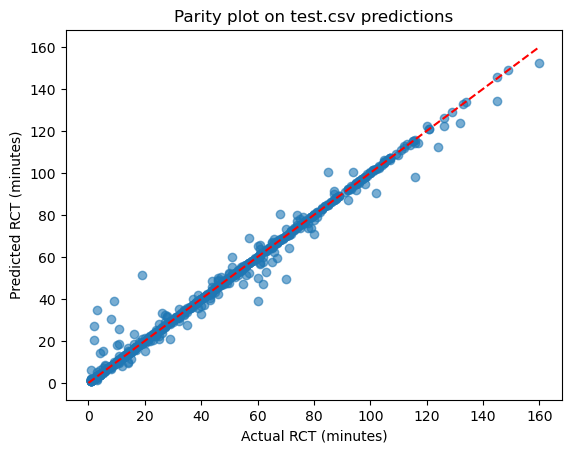

In [6]:
import matplotlib.pyplot as plt
y_true = df["rct_minutes"].values
plt.scatter(y_true, pred, alpha=0.6)
plt.plot([0, max(y_true)], [0, max(y_true)], 'r--')
plt.xlabel("Actual RCT (minutes)")
plt.ylabel("Predicted RCT (minutes)")
plt.title("Parity plot on test.csv predictions")
plt.show()


In [2]:
%pwd
%cd ..
import pandas as pd
from model.inference import predict_batch

df = pd.read_csv("./rct_train/test.csv")
X  = df.drop(columns=["rct_minutes"])
pred = predict_batch(X, model_dir="./model")
pred[:10]


/home/sagemaker-user/RCT NEW/rct_model_project


array([ 3.7597663, 75.13176  ,  2.0195   , 72.10982  , 71.32953  ,
       22.261047 , 60.076763 , 28.06921  , 53.531002 , 52.629913 ],
      dtype=float32)

/home/sagemaker-user/RCT NEW/rct_model_project


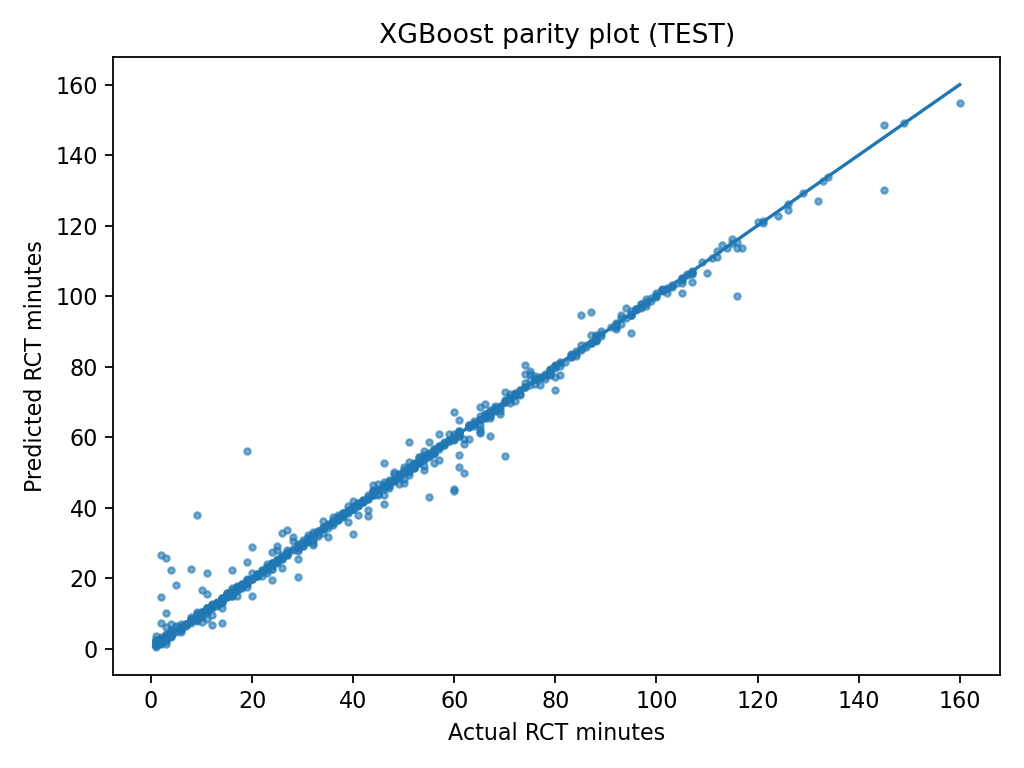

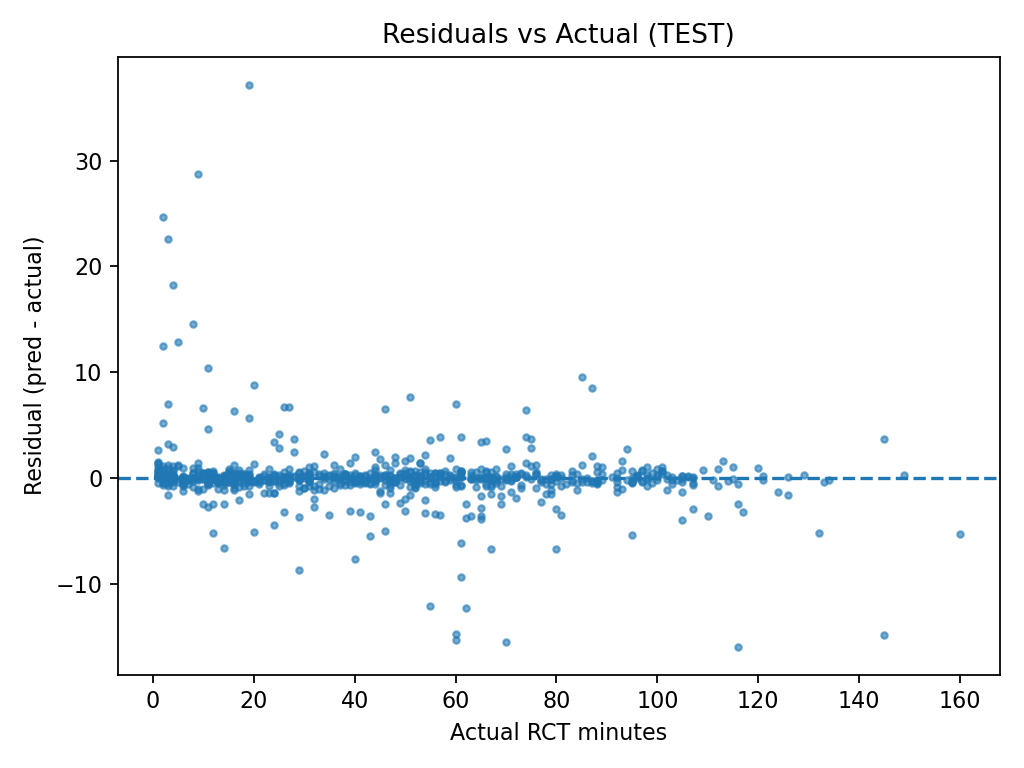

In [1]:
%pwd
%cd ..
import json, pandas as pd
from model.inference import predict_batch

# 2.1 Load test and re-evaluate metrics you saved
m = json.load(open("./model/metrics.json"))
m   # eyeball overall rmse/mae + by-band summaries

# 2.2 Parity & residuals are already saved; optionally re-display
from IPython.display import Image, display
display(Image("./model/parity_test.png"))
display(Image("./model/residuals_test.png"))

# 2.3 Hard guardrails: predictions should be >=0 and finite
df = pd.read_csv("./rct_train/test.csv")
pred = predict_batch(df.drop(columns=["rct_minutes"]), model_dir="./model").ravel()
assert pd.Series(pred).ge(0).all()


In [5]:
import sagemaker
print(sagemaker.Session().boto_region_name)


ap-southeast-2


In [6]:
import sagemaker
from sagemaker.serverless import ServerlessInferenceConfig
from sagemaker.xgboost.model import XGBoostModel

sess   = sagemaker.Session()
region = sess.boto_region_name
role   = sagemaker.get_execution_role()

model_data = "s3://bortana-sagemaker-analysis/bev2/models/rct/v0_1/model.tar.gz"

xgb_version = "1.7-1"
model = XGBoostModel(
    role=role,
    model_data=model_data,
    entry_point="inference.py",   # same file, it will be zipped into container
    framework_version=xgb_version
)

serverless_cfg = ServerlessInferenceConfig(
    memory_size_in_mb=2048,
    max_concurrency=5
)

predictor = model.deploy(
    serverless_inference_config=serverless_cfg,
    endpoint_name="rct-serverless-v01"
)

predictor.serializer   = sagemaker.serializers.JSONSerializer()
predictor.deserializer = sagemaker.deserializers.JSONDeserializer()


-------!

In [8]:
import sagemaker
print(sagemaker.get_execution_role())


arn:aws:iam::383868855578:role/BortanaSageMakerExecutionRole


In [12]:
import sagemaker
from sagemaker.serverless import ServerlessInferenceConfig
from sagemaker.xgboost.model import XGBoostModel

sess = sagemaker.Session()
region = sess.boto_region_name
role = sagemaker.get_execution_role()

model_data = "s3://bortana-sagemaker-analysis/bev2/models/rct/v0_1/model.tar.gz"

xgb_version = "1.7-1"
model = XGBoostModel(
    role=role,
    model_data=model_data,
    entry_point="inference.py",
    framework_version=xgb_version
)

serverless_cfg = ServerlessInferenceConfig(
    memory_size_in_mb=2048,
    max_concurrency=5
)

predictor = model.deploy(
    serverless_inference_config=serverless_cfg,
    endpoint_name="rct-serverless-v03"
)

predictor.serializer = sagemaker.serializers.JSONSerializer()
predictor.deserializer = sagemaker.deserializers.JSONDeserializer()


-----!

In [13]:
from sagemaker import Predictor
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

predictor = Predictor(
    endpoint_name="rct-serverless-v01",    # or v03 once it finishes creating
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer()
)


In [15]:
import pandas as pd

df = pd.read_csv("/home/sagemaker-user/RCT NEW/rct_model_project/rct_train/test.csv")


row = df.drop(columns=["rct_minutes"]).iloc[0].to_dict()
row


{'soc': 55.0,
 'soc_master': 55.0,
 'soc_slave': 53.0,
 'voltage': 360.4,
 'voltage_master': 360.26,
 'voltage_slave': 360.54,
 'current': -16.759999999999998,
 'current_master': -8.43,
 'current_slave': -8.33,
 'bms_temp': 9.0,
 'pack_delta': 20.84,
 'charge_limit': 15.0,
 'discharge_limit': 240.0,
 'km': 2200.0,
 'power_kw': -6.040303999999999,
 'soc_rate_per_min': 0.009999999999998,
 'temp_rise_rate': 0.0199999999999995,
 'elapsed_min': 1.0,
 'soc_delta_to_full': 45.0}

In [16]:
result = predictor.predict({"instances": [row]})
print(result)


{'predictions': [3.7597663402557373]}


In [4]:
%pwd
%cd ..
import boto3, time

sm = boto3.client("sagemaker")
prefix = "rct-serverless-v01"   # <-- adjust to the names you used

# 1) Endpoints
eps = [e["EndpointName"] for e in sm.list_endpoints(MaxResults=100)["Endpoints"]
       if prefix in e["EndpointName"]]
for name in eps:
    print("Deleting endpoint:", name)
    sm.delete_endpoint(EndpointName=name)

# wait until none remain in list (deleting is async)
while any(prefix in e["EndpointName"] for e in sm.list_endpoints(MaxResults=100)["Endpoints"]):
    print("…waiting for endpoint deletion…")
    time.sleep(10)

# 2) EndpointConfigs
cfgs = [c["EndpointConfigName"] for c in sm.list_endpoint_configs(MaxResults=100)["EndpointConfigs"]
        if prefix in c["EndpointConfigName"]]
for name in cfgs:
    print("Deleting endpoint-config:", name)
    sm.delete_endpoint_config(EndpointConfigName=name)

# 3) Models
mods = [m["ModelName"] for m in sm.list_models(MaxResults=100)["Models"]
        if prefix in m["ModelName"]]
for name in mods:
    print("Deleting model:", name)
    sm.delete_model(ModelName=name)

print("Cleanup complete.")


/home/sagemaker-user
Deleting endpoint-config: rct-serverless-v01
Cleanup complete.


In [7]:
import os, sagemaker
from sagemaker.serverless import ServerlessInferenceConfig
from sagemaker.xgboost.model import XGBoostModel

sess = sagemaker.Session()
role = sagemaker.get_execution_role()

# ← path that CONTAINS inference.py (adjust this!)
SRC_DIR = "/home/sagemaker-user/RCT NEW/rct_model_project"  # or os.path.abspath("..")

model_data = "s3://bortana-sagemaker-analysis/bev2/models/rct/v0_1/model.tar.gz"
xgb_version = "1.7-1"

model = XGBoostModel(
    role=role,
    model_data=model_data,
    framework_version=xgb_version,
    entry_point="inference.py",     # file exists inside SRC_DIR
    source_dir=SRC_DIR,             # <-- key fix
    sagemaker_session=sess,
    name="rct-xgb-svls-v02"
)

serverless_cfg = ServerlessInferenceConfig(memory_size_in_mb=2048, max_concurrency=5)

predictor = model.deploy(
    serverless_inference_config=serverless_cfg,
    endpoint_name="rct-serverless-v02",
    wait=True
)


-----!

In [9]:
import pandas as pd, numpy as np, os

SRC = "./output/features/rct/rct_all.csv"   # <- change if yours is .parquet or different path
df = pd.read_parquet(SRC) if SRC.endswith(".parquet") else pd.read_csv(SRC)
print("Rows:", len(df))
print("Columns:", df.columns.tolist())
# Accept either 'soc' or 'soc_master', and either 'current' or 'current_master'
soc_col = "soc" if "soc" in df.columns else ("soc_master" if "soc_master" in df.columns else None)
cur_col = "current" if "current" in df.columns else ("current_master" if "current_master" in df.columns else None)

missing = [c for c in ["session_id", "elapsed_min", soc_col, cur_col] if c not in df.columns]
print("Chosen SOC col:", soc_col, "Chosen current col:", cur_col)
assert "session_id" in df.columns and "elapsed_min" in df.columns and soc_col and cur_col, \
    f"Missing required columns: {missing}"
print(df[[soc_col, cur_col]].describe())

# SOC in [0,100]?
soc_out = df[(df[soc_col] < 0) | (df[soc_col] > 100)][["session_id","elapsed_min",soc_col]].head()
print("SOC outside [0,100] (showing up to 5 rows):")
display(soc_out)

# How many negative vs positive currents (just to know charge sign)
neg_pct = (df[cur_col] < 0).mean()*100
print(f"% rows with negative {cur_col} (often charge): {neg_pct:.1f}%")
# Make sure elapsed_min is numeric and sorted within sessions
df["elapsed_min"] = pd.to_numeric(df["elapsed_min"], errors="coerce")
bad_elapsed = df["elapsed_min"].isna().sum()
print("NaNs in elapsed_min:", bad_elapsed)

g = df.sort_values(["session_id","elapsed_min"]).groupby("session_id")
d = g["elapsed_min"].diff()  # minute step between consecutive rows in a session

# Distribution of step sizes (should be 1.0 for per-minute data)
vc = d.round(3).value_counts(dropna=True).sort_index()
print("Step size distribution (minutes):\n", vc.head(10))

# Sessions that are NOT strictly per minute (any step != 1)
non_1_sessions = d.groupby(df["session_id"]).apply(lambda s: (s.dropna() != 1).any())
print("Non-1.0 minute sessions (count):", int(non_1_sessions.sum()))
print("Example non-1.0 sessions:", non_1_sessions[non_1_sessions].index.tolist()[:5])
dups = df.duplicated(subset=["session_id","elapsed_min"]).sum()
print("Duplicate (session_id, elapsed_min) rows:", dups)
if dups:
    display(df[df.duplicated(subset=["session_id","elapsed_min"], keep=False)]
            .sort_values(["session_id","elapsed_min"]).head(10))
print("Nulls:\n", df[["session_id","elapsed_min",soc_col,cur_col]].isna().sum())


Rows: 1015
Columns: ['timestamp_local', 'soc', 'soc_master', 'soc_slave', 'voltage', 'voltage_master', 'voltage_slave', 'current', 'current_master', 'current_slave', 'cell_temp', 'bms_temp', 'pack_delta', 'charge_limit', 'discharge_limit', 'km', 'power_kw', 'session_id', 'soc_rate_per_min', 'temp_rise_rate', 'elapsed_min', 'rct_minutes', 'soc_delta_to_full']
Chosen SOC col: soc Chosen current col: current
               soc      current
count  1015.000000  1015.000000
mean     53.959951   -47.282640
std      18.192513    22.578599
min      16.870000   -95.140000
25%      38.000000   -55.225000
50%      55.030000   -53.740000
75%      72.000000   -34.505000
max      79.000000    -6.050000
SOC outside [0,100] (showing up to 5 rows):


,session_id,elapsed_min,soc


% rows with negative current (often charge): 100.0%
NaNs in elapsed_min: 0
Step size distribution (minutes):
 elapsed_min
1.0     962
2.0       3
3.0      12
4.0      13
5.0       4
6.0       1
8.0       1
10.0      2
Name: count, dtype: int64
Non-1.0 minute sessions (count): 12
Example non-1.0 sessions: [1, 2, 3, 5, 6]
Duplicate (session_id, elapsed_min) rows: 0
Nulls:
 session_id     0
elapsed_min    0
soc            0
current        0
dtype: int64


In [15]:
import pandas as pd, numpy as np, os

# 1) Load
SRC = "./output/features/rct/rct_all.csv"  # ← change if needed
if SRC.endswith(".parquet"):
    df = pd.read_parquet(SRC)
else:
    df = pd.read_csv(SRC)

# 2) Pick columns (auto-detect variants)
soc_col = "soc" if "soc" in df.columns else "soc_master"
cur_col = "current" if "current" in df.columns else "current_master"

df = df[["session_id", soc_col, "elapsed_min", cur_col]].rename(
    columns={soc_col: "soc", cur_col: "current"}
)

# Use absolute amps; negative for charge is common
df["current_abs"] = df["current"].astype(float).abs()

# SOC bands: [0,10), [10,20), ... [90,100]
soc_step = 10
soc_edges = list(range(0, 100 + soc_step, soc_step))
df["soc_band"] = pd.cut(df["soc"].clip(0, 100),
                        bins=soc_edges, right=False, include_lowest=True)

# Current bins (categorical with fixed display order)
cur_bins = [0, 1, 5, 10, np.inf]
cur_lbls = pd.CategoricalDtype(["≤1A", "1–5A", "5–10A", ">10A"], ordered=True)
df["current_bin"] = pd.cut(df["current_abs"], bins=cur_bins, right=True, include_lowest=True)
df["current_bin"] = df["current_bin"].map({
    pd.Interval(0,1,closed='both'):"≤1A", pd.Interval(0,1,closed='right'):"≤1A"
}).fillna(df["current_bin"].astype(str))  # keep ≤ for 0–1

# Normalize labels to the 4 desired strings
def label_bin(v):
    a = float(v.left) if hasattr(v, "left") else np.nan
    b = float(v.right) if hasattr(v, "right") else np.nan
    if np.isfinite(a) and np.isfinite(b):
        if b <= 1:  return "≤1A"
        if b <= 5:  return "1–5A"
        if b <= 10: return "5–10A"
    return ">10A"

df["current_bin"] = pd.Categorical(
    [label_bin(v) for v in pd.cut(df["current_abs"], bins=cur_bins, right=True, include_lowest=True)],
    dtype=cur_lbls
)

# One row = one minute → minutes_spent = count of rows
per_sess_band = (
    df.dropna(subset=["soc_band", "current_bin"])
      .groupby(["session_id", "soc_band"])
      .agg(minutes_spent=("elapsed_min", "count"),
           mean_current_abs=("current_abs", "mean"))
      .reset_index()
)

# Assign a bin to that session+band based on its mean current
per_sess_band["current_bin"] = pd.Categorical(
    [label_bin(v) for v in pd.cut(per_sess_band["mean_current_abs"], bins=cur_bins,
                                  right=True, include_lowest=True)],
    dtype=cur_lbls
)

lookup = (
    per_sess_band
      .groupby(["soc_band", "current_bin"], observed=True)
      .agg(avg_minutes=("minutes_spent", "median"),
           n_sessions=("minutes_spent", "size"))
      .reset_index()
)

# After:
# lookup = (per_sess_band
#   .groupby(["soc_band","current_bin"], observed=True)
#   .agg(avg_minutes=("minutes_spent","median"),
#        n_sessions=("minutes_spent","size"))
#   .reset_index())

# --- ensure full grid (all bins per band) ---
all_bins = pd.CategoricalDtype(["≤1A","1–5A","5–10A",">10A"], ordered=True)
lookup["current_bin"] = lookup["current_bin"].astype(all_bins)

# build a complete index (every soc_band present × all 4 bins)
bands = lookup["soc_band"].unique()
full_index = (
    pd.MultiIndex.from_product([bands, all_bins.categories],
                               names=["soc_band","current_bin"])
)

lookup = (lookup.set_index(["soc_band","current_bin"])
                .reindex(full_index)
                .reset_index())

# fill display values: 0 sessions where missing; minutes can stay NaN or 0
lookup["n_sessions"] = lookup["n_sessions"].fillna(0).astype(int)
# (optional) if you prefer 0.0 instead of NaN for avg_minutes:
# lookup["avg_minutes"] = lookup["avg_minutes"].fillna(0.0)

# pretty types
lookup["soc_band"] = lookup["soc_band"].astype(str)
lookup = lookup.sort_values(["soc_band","current_bin"])

table_60_70 = lookup.loc[lookup["soc_band"] == "[60, 70)"][
    ["soc_band","current_bin","avg_minutes","n_sessions"]
]
print(table_60_70.to_string(index=False))


soc_band current_bin  avg_minutes  n_sessions
[60, 70)        1–5A          NaN           0
[60, 70)       5–10A          NaN           0
[60, 70)        >10A         11.0          17
[60, 70)         ≤1A          NaN           0


/tmp/ipykernel_162/1353506754.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["session_id", "soc_band"])


In [31]:
import os, joblib, pandas as pd, numpy as np, xgboost as xgb

# ✅ Absolute path (no spaces or ambiguity)
MODEL_DIR = "/home/sagemaker-user/RCT NEW/rct_model_project/releases/v0_1"
model_path = f"{MODEL_DIR}/xgb.json"           # use XGBoost model
feature_list_path = f"{MODEL_DIR}/feature_list.txt"

# Confirm both files exist
print("Model exists:", os.path.exists(model_path))
print("Feature list exists:", os.path.exists(feature_list_path))

# Load feature list
with open(feature_list_path) as f:
    feature_list = [x.strip() for x in f.readlines()]

# Load XGBoost model
booster = xgb.Booster()
booster.load_model(model_path)

# Example current EV snapshot
sample = {
    "soc": 45.0,
    "soc_master": 45.0,
    "voltage_master": 714.3,
    "current_master": -18.2,
    "power_kw": 12.8,
    "cell_temp": 34.1,
    "bms_temp": 36.0,
    "pack_delta": 0.025,
    "soc_rate_per_min": 0.55,
    "soc_delta_to_full": 55.0,
    "km": 14780.0,
}

#  Prepare features for prediction
x = pd.DataFrame([[sample.get(c, np.nan) for c in feature_list]],
                 columns=feature_list)
dmatrix = xgb.DMatrix(x, feature_names=feature_list)

#  Predict remaining charging time
pred_minutes = booster.predict(dmatrix)[0]
print(f"\nPredicted time remaining to full (SOC 100%): {pred_minutes:.1f} minutes")

hrs = int(pred_minutes // 60)
mins = int(pred_minutes % 60)
print(f"≈ {hrs} hr {mins} min remaining to full charge")




Model exists: True
Feature list exists: True

Predicted time remaining to full (SOC 100%): -1.5 minutes
≈ -1 hr 58 min remaining to full charge


In [30]:
missing = [c for c in feature_list if c not in sample]
nan_cols = [c for c,v in dict(zip(feature_list, x.iloc[0].tolist())).items() if pd.isna(v)]
print("Missing in sample (set to NaN):", missing[:20], "… total:", len(missing))
print("NaN columns actually sent:", nan_cols[:20], "… total:", len(nan_cols))


Missing in sample (set to NaN): ['soc_slave', 'voltage', 'voltage_slave', 'current', 'current_slave', 'charge_limit', 'discharge_limit', 'temp_rise_rate', 'elapsed_min'] … total: 9
NaN columns actually sent: ['soc_slave', 'voltage', 'voltage_slave', 'current', 'current_slave', 'charge_limit', 'discharge_limit', 'temp_rise_rate', 'elapsed_min'] … total: 9


In [33]:
df_test = pd.read_csv("/home/sagemaker-user/RCT NEW/rct_model_project/rct_train/test.csv")   # adjust path if needed
X = df_test[feature_list].copy()
pred = booster.predict(xgb.DMatrix(X, feature_names=feature_list))
print("Median predicted RCT (test.csv):", float(pd.Series(pred).median()))


Median predicted RCT (test.csv): 40.711917877197266


In [34]:
import numpy as np, pandas as pd, xgboost as xgb

# y_true from your test split
df_test = pd.read_csv("/home/sagemaker-user/RCT NEW/rct_model_project/rct_train/test.csv")
X = df_test[feature_list].copy()
y = df_test["rct_minutes"].values

pred = booster.predict(xgb.DMatrix(X, feature_names=feature_list))

mae  = np.mean(np.abs(pred - y))
rmse = np.sqrt(np.mean((pred - y)**2))
p90  = np.percentile(np.abs(pred - y), 90)

print(f"TEST  MAE={mae:.2f} min  RMSE={rmse:.2f}  P90|err|={p90:.2f}")


TEST  MAE=1.23 min  RMSE=3.20  P90|err|=2.91


In [35]:
import numpy as np, pandas as pd, xgboost as xgb

def predict_rct_minutes(booster, feature_list, rows, clip_min=0.0, clip_max=240.0):
    """
    rows: list[dict] or pd.DataFrame with feature_list columns
    returns: dict with raw, clipped, and h:m strings
    """
    if isinstance(rows, dict):   # single dict
        rows = [rows]
    if isinstance(rows, list):
        df = pd.DataFrame([{c: r.get(c, np.nan) for c in feature_list} for r in rows],
                          columns=feature_list)
    else:
        df = rows[feature_list].copy()

    dm = xgb.DMatrix(df, feature_names=feature_list)
    raw = booster.predict(dm)
    clipped = np.clip(raw, clip_min, clip_max)

    def fmt(m): 
        m = max(0.0, float(m))
        h, mm = divmod(int(round(m)), 60)
        return f"{h} hr {mm} min"

    return {
        "raw_minutes": raw.tolist(),
        "rct_minutes": clipped.tolist(),
        "pretty": [fmt(m) for m in clipped]
    }

# example with one live row (fill as many features as you can)
out = predict_rct_minutes(booster, feature_list, sample)
print(out)


{'raw_minutes': [-1.4789074659347534], 'rct_minutes': [0.0], 'pretty': ['0 hr 0 min']}


In [40]:
import pandas as pd
import glob
import os

# Folder that contains your curated per-minute parquet files
FOLDER = "/home/sagemaker-user/RCT NEW/output/curated/rows"

# Read and combine all parquet files
files = sorted(glob.glob(os.path.join(FOLDER, "*.parquet")))
print("Found files:", files)

# Combine into one DataFrame
df = pd.concat([pd.read_parquet(f) for f in files], ignore_index=True)
print("Combined shape:", df.shape)

# Optional: save as CSV if you want a single file for later use
out_path = "/home/sagemaker-user/RCT NEW/output/curated_per_minute.csv"
df.to_csv(out_path, index=False)
print(" Saved combined dataset to:", out_path)



Found files: ['/home/sagemaker-user/RCT NEW/output/curated/rows/2025-06.parquet', '/home/sagemaker-user/RCT NEW/output/curated/rows/2025-07.parquet', '/home/sagemaker-user/RCT NEW/output/curated/rows/2025-08.parquet', '/home/sagemaker-user/RCT NEW/output/curated/rows/2025-09.parquet']
Combined shape: (21575, 19)
 Saved combined dataset to: /home/sagemaker-user/RCT NEW/output/curated_per_minute.csv


In [43]:
print(df.columns.tolist())
df.head(3)


['soc', 'soc_master', 'soc_slave', 'voltage', 'voltage_master', 'voltage_slave', 'current', 'current_master', 'current_slave', 'power_kw', 'speed', 'idle', 'cell_temp', 'bms_temp', 'pack_delta', 'charge_limit', 'discharge_limit', 'km', 'session_id', 'soc_band', 'current_abs', 'current_bin']


,soc,soc_master,soc_slave,voltage,voltage_master,voltage_slave,current,current_master,current_slave,power_kw,...,cell_temp,bms_temp,pack_delta,charge_limit,discharge_limit,km,session_id,soc_band,current_abs,current_bin
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,47.83,47.83,47.62,323.455,323.31,323.60,7.25,3.51,3.74,2.345049,...,NaN,6.44,14.18,12.93,206.88,2200.0,NaN,"[40.0, 50.0)",3.51,1–5A
2,55.00,55.00,52.00,356.860,356.79,356.93,4.90,2.33,2.57,1.748614,...,NaN,7.00,15.78,15.00,240.00,2200.0,NaN,"[50.0, 60.0)",2.33,1–5A


In [46]:
import os, glob, numpy as np, pandas as pd, xgboost as xgb

# ====== PATHS ======
MODEL_DIR = "/home/sagemaker-user/RCT NEW/rct_model_project/releases/v0_1"
MODEL_PATH = f"{MODEL_DIR}/xgb.json"
FEATS_PATH = f"{MODEL_DIR}/feature_list.txt"

LOOKUP_GLOB = "/home/sagemaker-user/**/lookup_minutes_by_soc_band_current.csv"  # existing lookup
PARQUET_DIR = "/home/sagemaker-user/RCT NEW/output/curated/rows"                # monthly parquet files
LOOKUP_OUT  = "/home/sagemaker-user/RCT NEW/soc_intervals/lookup_minutes_by_soc_band_current.csv"

# ======  Load model & feature list ======
booster = xgb.Booster()
booster.load_model(MODEL_PATH)

with open(FEATS_PATH) as f:
    FEATURE_LIST = [ln.strip() for ln in f if ln.strip()]

# ======  Load or build the SOC–Current lookup ======
cands = glob.glob(LOOKUP_GLOB, recursive=True)
if cands:
    LOOKUP_PATH = cands[0]
    lookup = pd.read_csv(LOOKUP_PATH)
    print(f" Loaded existing lookup from: {LOOKUP_PATH}")
else:
    parts = sorted(glob.glob(os.path.join(PARQUET_DIR, "*.parquet")))
    if not parts:
        raise FileNotFoundError(
            f"No lookup CSV or parquet parts found under: {PARQUET_DIR}"
        )
    print(f" Merging parquet parts: {parts}")
    df = pd.concat([pd.read_parquet(p) for p in parts], ignore_index=True)

    # choose current column, take absolute amps
    curcol = "current_master" if "current_master" in df.columns else "current"
    df["current_abs"] = df[curcol].astype(float).abs()

    # SOC bands (10% width)
    soc_edges = list(range(0, 101, 10))
    df["soc_band"] = pd.cut(df["soc"].clip(0,100), soc_edges, right=False, include_lowest=True)

    # Current bins
    cur_bins = [0, 1, 5, 10, np.inf]
    cur_lbls = ["≤1A","1–5A","5–10A",">10A"]
    df["current_bin"] = pd.cut(df["current_abs"], bins=cur_bins, labels=cur_lbls,
                               right=True, include_lowest=True)

    # Ensure elapsed_min (or fallback 1.0 per row)
    if "elapsed_min" not in df.columns:
        if "timestamp" in df.columns:
            df["timestamp"] = pd.to_datetime(df["timestamp"])
            df = df.sort_values(["session_id","timestamp"])
            df["elapsed_min"] = (
                df.groupby("session_id")["timestamp"]
                  .transform(lambda x: (x - x.min()).dt.total_seconds()/60)
            )
            print("⏱ elapsed_min created from timestamp")
        else:
            df["elapsed_min"] = 1.0
            print("⚠️ No timestamp found — synthetic elapsed_min = 1 minute per row")

    # Group by session × band
    per = (df.dropna(subset=["soc_band","current_bin"])
             .groupby(["session_id","soc_band"], observed=True)
             .agg(minutes_spent=("elapsed_min","count"),
                  mean_current_abs=("current_abs","mean"))
             .reset_index())

    per["current_bin"] = pd.cut(per["mean_current_abs"], bins=cur_bins, labels=cur_lbls,
                                right=True, include_lowest=True)

    # Build lookup table
    lookup = (per.groupby(["soc_band","current_bin"], observed=True)
                .agg(avg_minutes=("minutes_spent","median"),
                     n_sessions=("minutes_spent","size"))
                .reset_index())

    os.makedirs(os.path.dirname(LOOKUP_OUT), exist_ok=True)
    lookup.to_csv(LOOKUP_OUT, index=False)
    print(f"✅ Lookup built and saved to: {LOOKUP_OUT}")

# --- Normalize lookup labels ---
lookup["soc_band"] = lookup["soc_band"].astype(str).str.replace(".0", "", regex=False)
lookup["current_bin"] = lookup["current_bin"].astype(str).str.strip()

# ======  Helper functions ======
def band_label_for_soc(soc: float) -> str:
    """Return the 10% SOC band label for a given SOC."""
    lo = int(np.floor(soc/10)*10)
    hi = lo + 10
    return f"[{lo}, {hi})"

def current_bin_for_amps(a: float) -> str:
    """Return readable current bin label for a given amp value."""
    a = abs(float(a))
    if a <= 1:  return "≤1A"
    if a <= 5:  return "1–5A"
    if a <= 10: return "5–10A"
    return ">10A"

def band_minutes_from_lookup(band_label: str, cur_bin: str):
    """Fetch median minutes for that SOC band × current range."""
    row = lookup[(lookup["soc_band"]==band_label) & (lookup["current_bin"]==cur_bin)]
    return float(row["avg_minutes"].iloc[0]) if len(row) else np.nan

def sum_minutes_between(start_pct: int, end_pct: int, cur_bin: str):
    """Sum lookup minutes from start% to end% SOC for a fixed current bin."""
    bands = [f"[{b}, {b+10})" for b in range(start_pct, end_pct, 10)]
    vals = [band_minutes_from_lookup(b, cur_bin) for b in bands]
    vals = [v for v in vals if pd.notna(v)]
    return float(np.sum(vals)) if vals else np.nan

# ======  Example snapshot (50–80% window) ======
sample = {
    "soc": 55.0,                 # current SOC
    "current_master": 3.0,       # amps
    "voltage_master": 720.0,
    "soc_rate_per_min": 0.6,
    "soc_delta_to_full": 45.0,
    "km": 15000.0,
}

# Override or detect current bin
CURRENT_BIN_OVERRIDE = "1–5A"   # None to auto-detect
cur_bin_now = current_bin_for_amps(sample.get("current_master", 0.0))
cur_bin_use = CURRENT_BIN_OVERRIDE or cur_bin_now

# ======  Predict RCT (minutes to 100%) ======
X = pd.DataFrame([[sample.get(c, np.nan) for c in FEATURE_LIST]], columns=FEATURE_LIST)
pred = float(booster.predict(xgb.DMatrix(X, feature_names=FEATURE_LIST))[0])
pred = max(0.0, pred)

# ====== Compute interpretability fields ======
soc_now = float(sample["soc"])
band_now = band_label_for_soc(soc_now)
band_min = band_minutes_from_lookup(band_now, cur_bin_use)
to_50_80 = sum_minutes_between(50, 80, cur_bin_use)

# ======  Final output JSON ======
result = {
    "predictions": [round(pred, 1)],
    "band_interval_minutes": (
        f"{band_now.replace('[','').replace(')','')} @ {cur_bin_use} → "
        f"{int(round(band_min))} min"
        if pd.notna(band_min)
        else "No data in lookup"
    ),
    "to_full_lookup_sum": None if pd.isna(to_50_80) else round(to_50_80, 1)
}

print("\n Final Output:")
print(result)


 Loaded existing lookup from: /home/sagemaker-user/RCT NEW/soc_intervals/lookup_minutes_by_soc_band_current.csv

 Final Output:
{'predictions': [1.8], 'band_interval_minutes': '50, 60 @ 1–5A → 1 min', 'to_full_lookup_sum': 2.0}


In [1]:
import sys, os
sys.path.append("/home/sagemaker-user/RCT NEW/rct_model_project")

from model.inference import predict_batch
import pandas as pd

# Example: load a session file (replace with your path)
df = pd.read_csv("/home/sagemaker-user/RCT NEW/rct_model_project/rct_train/test.csv")

# optional: inspect columns
df.head()
# Use absolute current range 10–15 A
mask = (df["soc"] >= 20) & (df["soc"] <= 80) & (df["current"].abs().between(10, 15))
df_filtered = df[mask].copy()

print("Filtered rows:", len(df_filtered))
from model.inference import predict_batch

# Drop the target if present
X = df_filtered.drop(columns=["rct_minutes"], errors="ignore")

# Predict using your trained model
df_filtered["predicted_rct"] = predict_batch(X, model_dir=".")


df_filtered.head()
# Define SOC bands
bins = [20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]
labels = [f"{bins[i]}–{bins[i+1]}%" for i in range(len(bins)-1)]

df_filtered["soc_band"] = pd.cut(df_filtered["soc"], bins=bins, labels=labels, include_lowest=True)

# Compute average predicted time per band (minutes)
soc_summary = (
    df_filtered.groupby("soc_band")["predicted_rct"]
    .mean()
    .reset_index(name="avg_predicted_minutes")
)

# Compute total predicted time (sum)
total_time = df_filtered["predicted_rct"].sum()

print(soc_summary)
print(f"\nTotal predicted time from 20%→80% SOC = {total_time:.2f} minutes")

# Take starting and ending RCT predictions
start_rct = df_filtered.loc[df_filtered["soc"].between(20,25), "predicted_rct"].mean()
end_rct   = df_filtered.loc[df_filtered["soc"].between(75,80), "predicted_rct"].mean()
approx_time = start_rct - end_rct
print(f"Estimated total charge time (20→80% SOC) ≈ {approx_time:.1f} minutes ({approx_time/60:.2f} hours)")



Filtered rows: 78
   soc_band  avg_predicted_minutes
0    20–25%              65.674324
1    25–30%              75.768250
2    30–35%              49.852203
3    35–40%              38.142654
4    40–45%              51.563129
5    45–50%              45.756817
6    50–55%              21.602770
7    55–60%              88.915855
8    60–65%              18.072336
9    65–70%              18.151823
10   70–75%              40.164318
11   75–80%              24.431818

Total predicted time from 20%→80% SOC = 3379.57 minutes
Estimated total charge time (20→80% SOC) ≈ 41.2 minutes (0.69 hours)


/tmp/ipykernel_159/2000407354.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_filtered.groupby("soc_band")["predicted_rct"]


In [2]:
import os, numpy as np, pandas as pd

MODEL_DIR = "./rct_model_project/model"   # adjust if different
TRAIN_DIR = "./rct_model_project/rct_train"  # has feature_list.txt and test.csv

def load_feature_list(model_dir=MODEL_DIR):
    with open(os.path.join(model_dir, "feature_list.txt"), "r") as f:
        return [ln.strip() for ln in f if ln.strip()]

def order_features(df, model_dir=MODEL_DIR):
    feats = load_feature_list(model_dir)
    # keep only model features, fill missing with NaN
    out = pd.DataFrame({c: df.get(c, np.nan) for c in feats})
    return out[feats]

def smooth_series(s, win=3):
    return s.rolling(win, center=True, min_periods=1).median()

def interp_at(x, y, xq):
    """x increasing; linear interpolation; clip to ends."""
    x = np.asarray(x); y = np.asarray(y)
    xq = np.asarray(xq, dtype=float)
    return np.interp(xq, x, y, left=y[0], right=y[-1])
import xgboost as xgb

# Load test rows to demonstrate (you can swap this for your own rows)
df = pd.read_csv(os.path.join(TRAIN_DIR, "test.csv"))

X = order_features(df)
dmat = xgb.DMatrix(X.values)
bst = xgb.Booster()
bst.load_model(os.path.join(MODEL_DIR, "xgb.json"))
df["predicted_rct"] = bst.predict(dmat)
# choose your bin edges (5% bands)
soc_bins = list(range(20, 85, 5)) + [80]  # 20,25,...,80
labels = [f"{soc_bins[i]}–{soc_bins[i+1]}%" for i in range(len(soc_bins)-1)]

# robust current columns (use what exists)
cand_master = [c for c in df.columns if "current" in c and "slave" not in c]
cand_slave  = [c for c in df.columns if "current" in c and "slave" in c]
i_master_col = cand_master[0] if cand_master else None
i_slave_col  = cand_slave[0]  if cand_slave  else None

def bucket_label(x, edges=(0,1,5,10,20,40,80,200,1000)):
    for a,b in zip(edges[:-1], edges[1:]):
        if a <= x < b:
            return f"{a}–{b} A"
    return f"{edges[-2]}+ A"

def summarize_session(sess_df):
    s = sess_df.sort_values("soc").copy()
    # smooth the cumulative predictions a bit to remove tiny wiggles
    s["predicted_rct_smooth"] = smooth_series(s["predicted_rct"])

    # interpolate cumulative RCT at bin edges
    rct_at = lambda p: float(interp_at(s["soc"], s["predicted_rct_smooth"], p))

    rows = []
    for lo, hi, lab in zip(soc_bins[:-1], soc_bins[1:], labels):
        rct_lo = rct_at(lo)
        rct_hi = rct_at(hi)
        minutes_in_band = max(0.0, rct_lo - rct_hi)  # <-- **the key fix**

        # pick currents within [lo,hi)
        band = s[(s["soc"] >= lo) & (s["soc"] < hi)]
        i_median_master = float(np.median(np.abs(band[i_master_col]))) if i_master_col else np.nan
        i_median_slave  = float(np.median(np.abs(band[i_slave_col])))  if i_slave_col  else np.nan

        rows.append({
            "soc_band": lab,
            "minutes_in_band": minutes_in_band,
            "master_current_bucket": bucket_label(i_median_master) if not np.isnan(i_median_master) else None,
            "slave_current_bucket":  bucket_label(i_median_slave)  if not np.isnan(i_median_slave)  else None,
            "median_master_A": i_median_master,
            "median_slave_A":  i_median_slave,
        })
    return pd.DataFrame(rows)

# Run for every session id/key you have
sid_col = "session_key" if "session_key" in df.columns else ("session_id" if "session_id" in df.columns else None)
assert sid_col is not None, "Need session_key or session_id in df."

band_tables = []
for sid, g in df.groupby(sid_col):
    t = summarize_session(g)
    t[sid_col] = sid
    band_tables.append(t)
result = pd.concat(band_tables, ignore_index=True)

# Fleet-level average per band (what you expected to see)
fleet = (result.groupby("soc_band")["minutes_in_band"]
         .mean().reset_index().rename(columns={"minutes_in_band":"avg_minutes"}))
fleet
def total_time_between(sess_df, a, b):
    s = sess_df.sort_values("soc").copy()
    s["predicted_rct_smooth"] = smooth_series(s["predicted_rct"])
    rct_at = lambda p: float(interp_at(s["soc"], s["predicted_rct_smooth"], p))
    return max(0.0, rct_at(a) - rct_at(b))

per_sess_20_80 = df.groupby(sid_col).apply(lambda g: total_time_between(g, 20, 80))
float(per_sess_20_80.mean())
display(
    fleet.assign(avg_minutes=lambda d: d["avg_minutes"].round(2))
)


FileNotFoundError: [Errno 2] No such file or directory: './rct_model_project/rct_train/test.csv'

In [3]:
import os
MODEL_DIR = os.path.expanduser("~/rct_model_project/model")
TRAIN_DIR = os.path.expanduser("~/rct_model_project/rct_train")  # <- not ./rct_model_project

import pandas as pd
df = pd.read_csv(os.path.join(TRAIN_DIR, "test.csv"))


FileNotFoundError: [Errno 2] No such file or directory: '/home/sagemaker-user/rct_model_project/rct_train/test.csv'